# OFDM Tutorial & Exploration

We consider first the non-cyclic-prefix OFDM symbol.

A single OFDM symbol is defined by $N$ sub-carriers, each with possibly different modulations. The different sub-carrier modulated symbols $s_k$ are then combined to give a _single_ final OFDM symbol via an IFFT:

$$
x[n] = \sum^{N-1}_{k=0} s_k e^{i 2 \pi k n / N}, \, n = {0, 1, ..., N-1}
$$

So far so good. Let's consider what we have to do at the receiver to demodulate this.

The obvious thing is to do the reverse, i.e. an FFT (where we have ignored the normalization):

\begin{align}
y[m] &= \sum^{N-1}_{n=0} x[n] e^{-i 2 \pi mn / N} \\
&= \sum^{N-1}_{n=0} \sum^{N-1}_{k=0} s_k e^{i 2 \pi k n / N} e^{-i 2 \pi m n / N}
\end{align}

Via orthogonality of Fourier components, we assume and perform the standard delta function substitution:

$$
y[m] = \sum^{N-1}_{k=0} s_k \delta(k - m) = s_m
$$

## Effect of Timing Offsets

What happens when you don't sample exactly at the start of the symbol? Let's consider sampling exactly 1 subcarrier symbol away from the correct value, that is:

$$
y[m] = \sum^{N-1}_{n=0} x[n-1] e^{-i 2 \pi m n / N}
$$

Note how $x[n] \rightarrow x[n-1]$ here, before we take the FFT. Then,


\begin{align}
y[m] &= \sum^{N-1}_{n=0} \sum^{N-1}_{k=0} s_k e^{i 2 \pi k (n-1) / N} e^{-i 2 \pi m n / N} \\
&= \sum^{N-1}_{n=0} \sum^{N-1}_{k=0} s_k e^{i 2 \pi k n / N} e^{-i 2 \pi m n / N} e^{-i 2 \pi k / N} \\
&= \sum^{N-1}_{k=0} s_k \delta(k - m) e^{-i 2 \pi k / N} \\
&= s_m e^{-i 2 \pi m / N}
\end{align}


In other words, the timing offset causes a phase shift proportional to the subcarrier index for each symbol! This is akin to laying out the subcarrier symbols in time as a 'normal' non-OFDM signal, and then frequency shifting the signal.

What about non-integer subcarrier symbol offsets? This is common in oversampled scenarios, where the number of samples between each subcarrier is the OSR or oversampling rate. Consider an arbitrary shift $\beta$, where $\beta < 1$. Then the above equation will reduce similarly to

$$
y[m] = s_m e^{-i 2 \pi \alpha m / N}
$$

so it is still akin to a frequency shift for a 'normal' signal.

[3 3 3 3 1 2 2 3 1 0 3 1 2 2 1 1 0 3 1 2 0 0 1 1 0 3 0 2 3 0 1 3 3 0 2 2 1
 1 0 0 1 0 1 0 0 1 0 0 2 3 2 3 1 1 2 3 1 3 2 3 0 3 3 0 0 2 3 1 3 1 2 1 1 2
 0 3 0 3 3 0 2 0 1 2 3 0 0 0 0 0 0 3 3 2 0 3 1 0 2 3 3 0 1 0 0 3 2 2 2 1 1
 2 1 0 2 3 3 0 3 2 2 2 2 0 2 1 3 2]
256
Ave noise power = 0.00019889987778328082
Ave sig power = 0.007516468772837332
Expected noise power = 0.0002
[3 3 3 3 1 2 2 3 1 0 3 1 2 2 1 1 0 3 1 2 0 0 1 1 0 3 0 2 3 0 1 3 3 0 2 2 1
 1 0 0 1 0 1 0 0 1 0 0 2 3 2 3 1 1 2 3 1 3 2 3 0 3 3 0 0 2 3 1 3 1 2 1 1 2
 0 3 0 3 3 0 2 0 1 2 3 0 0 0 0 0 0 3 3 2 0 3 1 0 2 3 3 0 1 0 0 3 2 2 2 1 1
 2 1 0 2 3 3 0 3 2 2 2 2 0 2 1 3 2]


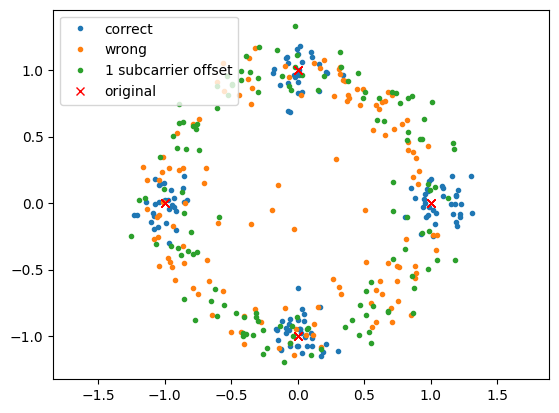

In [52]:
%matplotlib inline
import numpy as np
from signalCreationRoutines import *
from plotRoutines import *

closeAllFigs()

# Generate a simple OFDM symbol full of QPSK carriers
nfft = 128
subcarriers, bits = randPSKsyms(128, 4)
print(bits)
ofdm = np.fft.ifft(subcarriers)

# Receive an oversampled version after passing through a pulse shaping filter
osr = 2
rx = sps.resample_poly(ofdm, osr, 1)
print(rx.size)

# Add some noise
noise, rx = addSigToNoise(rx.size*2, osr, rx, 1, osr, 10000)

# # View the spectra
# sfig, sax = plotSpectra([rx], [1])

# Downsample then take the FFT
rxofdm_1subOff = rx[:ofdm.size*osr:osr]
rxofdm_wrong = rx[1:1+ofdm.size*osr:osr]
rxofdm_correct = rx[osr:osr+ofdm.size*osr:osr]
rxofdm_subcarriers = np.fft.fft(
    np.vstack((rxofdm_correct, rxofdm_wrong, rxofdm_1subOff)), 
    axis=1
)
 
# Look at constellation for correct and wrong downsampled time indices
plotted = [x for x in rxofdm_subcarriers]
plotted.append(subcarriers)
plotConstellation(
    plotted, 
    fmt=['.','.','.','rx'], labels=['correct', 'wrong', '1 subcarrier offset', 'original'])

# Demod the subcarriers here
def simpleSubcarrierDemod(rx_subcarriers: np.ndarray) -> np.ndarray:
    demod = np.round(np.angle(rx_subcarriers) / (np.pi/2)).astype(np.int32)
    demod[demod<0] += 4 # Specific to QPSK 
    return demod

# print(rxofdm_subcarriers[0])
demod = simpleSubcarrierDemod(rxofdm_subcarriers[0])

print(np.abs(demod))

if not np.all(np.abs(demod) == bits):
    print('Demodulation failed!')


## Effects of Frequency Offsets

What happens when the OFDM symbol is not tuned to the correct frequency? Here we assume the received symbol is now given by

$$
x[n] \rightarrow x[n] e^{i 2 \pi f n}, \,\, f \in [0, 1)
$$

where we have defined a _normalized_ frequency offset $f$.

The above analysis then no longer reduces to a delta function as the summation over $n$ now depends on the tone as well.

$$
y[m] = \sum^{N-1}_{n=0} \sum^{N-1}_{k=0} s_k e^{i 2 \pi k n / N} e^{-i 2 \pi m n / N} e^{i 2 \pi f n}
$$

What this does in practice is to cause the initial subcarrier modulated symbols to be 'de-mixed' improperly, usually resulting in pure noise-looking constellation plots.

There is a special case in which this doesn't occur, and that is when the frequency is equivalent to an integer number of bins, i.e.

$$
e^{i 2 \pi f n} = e^{i 2 \pi \alpha n / N}
$$

Then,

$$
y[m] = \sum^{N-1}_{k=0} s_k \delta(k - (m - \alpha))
$$

In other words, we have a circularly rotated mapping of the OFDM symbol's subcarriers; e.g. $0 \rightarrow 1, ..., N-1 \rightarrow 0$. This is _only_ if the OFDM symbol is processed while critically sampled. In oversampled scenarios, the subcarriers would be shifted out of the 'centre' region and hence some subcarriers would be lost.

[[3 3 3 3 1 2 2 3 1 0 3 1 2 2 1 1 0 3 1 2 0 0 1 1 0 3 0 2 3 0 1 3 3 0 2 2
  1 1 0 0 1 0 1 0 0 1 0 0 2 3 2 3 1 1 2 3 1 3 2 3 0 3 3 0 0 2 3 1 3 1 2 1
  1 2 0 3 0 3 3 0 2 0 1 2 3 0 0 0 0 0 0 3 3 2 0 3 1 0 2 3 3 0 1 0 0 3 2 2
  2 1 1 2 1 0 2 3 3 0 3 2 2 2 2 0 2 1 3 2]
 [2 3 3 3 3 1 2 2 3 1 0 3 1 2 2 1 1 0 3 1 2 0 0 1 1 0 3 0 2 3 0 1 3 3 0 2
  2 1 1 0 0 1 0 1 0 0 1 0 0 2 3 2 3 1 1 2 3 1 3 2 3 0 3 3 0 0 2 3 1 3 1 2
  1 1 2 0 3 0 3 3 0 2 0 1 2 3 0 0 0 0 0 0 3 3 2 0 3 1 0 2 3 3 0 1 0 0 3 2
  2 2 1 1 2 1 0 2 3 3 0 3 2 2 2 2 0 2 1 3]]


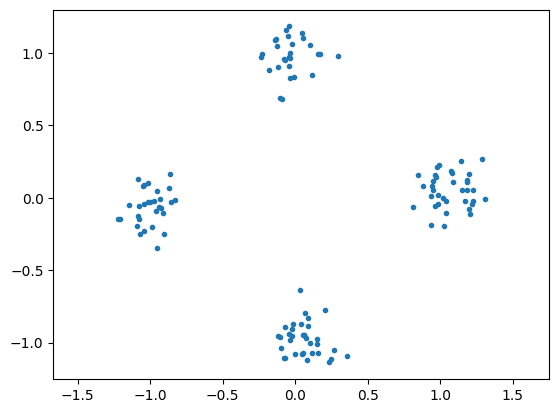

In [58]:
# Induce integer subcarrier frequency offset
rxshift = rx * np.exp(1j*2*np.pi*1/(nfft*osr) * np.arange(rx.size))
# Demod the OFDM symbol again
rxshiftofdm = np.fft.fft(rxshift[osr:osr+ofdm.size*osr:osr])
# Show constellation
plotConstellation(rxshiftofdm)

# Demod ofdm subcarriers
demodshift = simpleSubcarrierDemod(rxshiftofdm)
# We should see a rotation of 1 bin here
print(np.vstack((bits, demodshift)))


